In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import datetime
import geopandas as gpd

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import helper

In [2]:
import matplotlib.style as style
plt.style.use("markerr.mplstyle")

In [28]:
acs = pd.read_csv('acs2_clean.csv', index_col = 0,
                   parse_dates=['Time']
                  )


In [29]:
zri = pd.read_csv('long_interpolated_target.csv', index_col = 0,
                   parse_dates=['Time']
                  )

# source: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2018.html
zips = gpd.read_file('cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp')
zips['GEOID10'] = zips['GEOID10'].astype(int)
target_zips = pd.read_csv('target.csv', index_col = 0)



#### prepping for mapping 

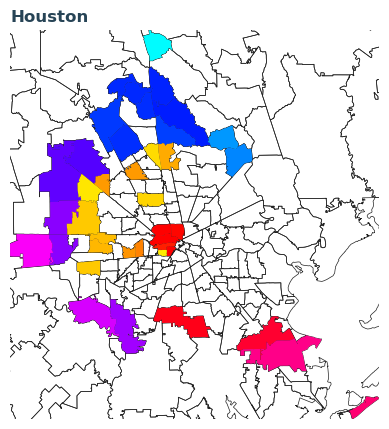

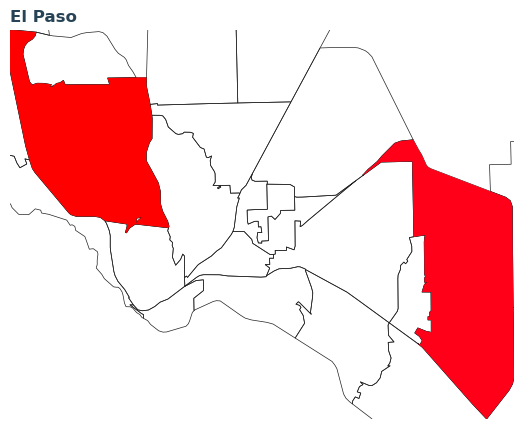

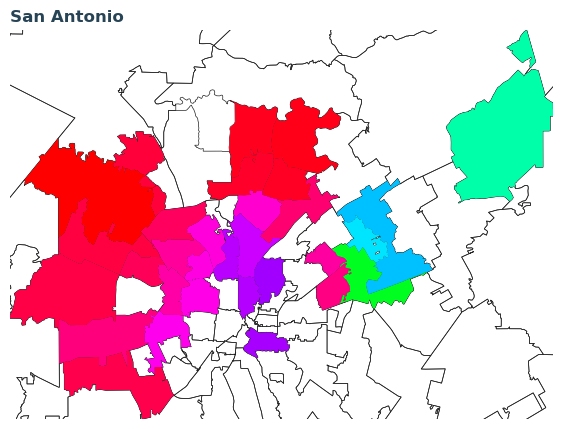

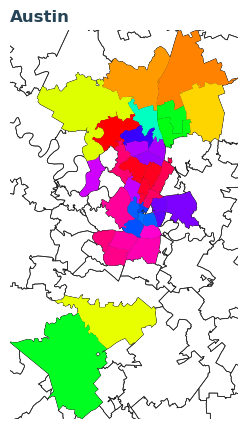

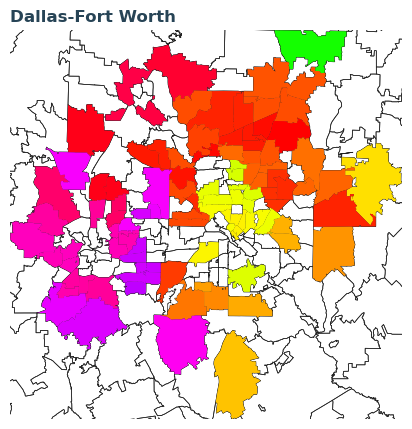

In [5]:
# lists of relevent zipcodes
houston_zips_list = list(target_zips[target_zips['City']=='Houston']['zip_code'].unique())
paso_zips_list = list(target_zips[target_zips['City']=='El Paso']['zip_code'].unique())
san_zips_list = list(target_zips[target_zips['City']=='San Antonio']['zip_code'].unique())
austin_zips_list = list(target_zips[target_zips['City']=='Austin']['zip_code'].unique())
dallas_zips_list = list(target_zips[target_zips['City']=='Dallas-Fort Worth']['zip_code'].unique())

# limitting the zips to just inside the region around TX 
zips = zips[zips['AFFGEOID10'].str[0:10] == '8600000US7'].reset_index()

# limiting to the inidvidual regions of interest
houston_zips = zips.loc[zips.loc[:,'GEOID10'].isin(houston_zips_list),:]
paso_zips = zips.loc[zips.loc[:,'GEOID10'].isin(paso_zips_list),:]
san_zips = zips.loc[zips.loc[:,'GEOID10'].isin(san_zips_list),:]
austin_zips = zips.loc[zips.loc[:,'GEOID10'].isin(austin_zips_list),:]
dallas_zips = zips.loc[zips.loc[:,'GEOID10'].isin(dallas_zips_list),:]

# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    different_metros[metro].plot(ax=zip_boundry_map, zorder=2, legend=False, column = 'GEOID10', cmap='hsv')

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = different_metros[metro].total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro)
    plt.show()

### now 12 month lag

In [30]:
# zri_shift 6-12 months
zri_shift, zri_shift_X_vals = helper.time_lag_merge(zri, zri, {
    12:['zori_ssa'],
    13:['zori_ssa'],
    18:['zori_ssa'],
    24:['zori_ssa']
},
                                          return_cols = True
                                         )
zri_shift = zri_shift.dropna(axis='index',how = 'any').reset_index(drop = True)
# Adding the shift values
zri_shift.loc[:,'zori_ssa_1_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_13_month_shift'])
zri_shift.loc[:,'zori_ssa_6_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_18_month_shift'])
zri_shift.loc[:,'zori_ssa_12_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_24_month_shift'])
zri_shift = zri_shift[['Time','zip_code','zori_ssa', 'zori_ssa_12_month_shift',
                       'zori_ssa_18_month_shift',
                       'zori_ssa_1_diff_lag_12', 'zori_ssa_6_diff_lag_12',
                       'zori_ssa_12_diff_lag_12']]
zri_shift['zori_ssa_12_diff_lag_12_per'] = (zri_shift['zori_ssa_12_diff_lag_12']/
                                           zri_shift['zori_ssa_12_month_shift'])



Adding a lag to acs so that i can put in a percent differnce from the year before and not just the actual values per zip

In [31]:
acs_shift, acs_shift_X_vals = helper.time_lag_merge(acs, acs, {
    12:['commuting_population',
 'divorced_men',
 'driving_alone_population',
 'housing_units_built_1940_to_1949',
 'quintile_2_income_share',
 'housing_units_10_to_19_units_rented',
 'quintile_3_income_share',
 'married_women_spouse_absent',
 'female_80_to_84',
 'female_45_to_49',
 'female_75_to_79',
 'married_men',
 'motorcycle_population',
 'female_60_to_61',
 'male_20',
 'housing_units_10_to_19_units_owned',
 'male_21',
 'men_with_professional_degree',
 'housing_units_over_50_units_rented',
 'quintile_5_income_share',
 'housing_units_single_family_detached_rented',
 'housing_units_built_1950_to_1959',
 'women_with_professional_degree',
 'total_contract_rent',
 'bicycle_population',
 'male_30_to_34',
 'housing_units_other_type',
 'male_18_to_19',
 'average_household_size_renters',
 'other_commute_method_population',
 'male_50_to_54',
 'married_men_spouse_absent',
 'marital_status_population',
 'housing_units_3_to_4_units_owned',
 'quintile_4_upper_limit',
 'quintile_3_upper_limit',
 'men_with_associate_degree',
 'women_with_one_year_or_more_college',
 'housing_units_10_to_19_units',
 'housing_units_built_1970_to_1979',
 'quintile_4_income_share',
 'total_units',
 'median_household_income',
 'women_with_doctoral_degree',
 'female_21',
 'housing_units_single_family_detached',
 'housing_units_20_to_49_units_rented',
 'renter_occupied_units',
 'housing_units_single_family_detached_owned',
 'women_with_less_one_year_college',
 'taxi_population',
 'female_62_to_64',
 'working_from_home_population',
 'total_households',
 'median_contract_rent',
 'female_22_to_24',
 'male_62_to_64',
 'occupied_units',
 'married_men_spouse_present',
 'male_67_to_69',
 'quintile_1_mean_income',
 'median_rooms',
 'female_50_to_54',
 'median_gross_rent',
 'male_22_to_24',
 'median_age',
 'female_55_to_59',
 'housing_units_mobile_home_rented',
 'housing_units_built_1980_to_1989',
 'housing_units_5_to_9_units_owned',
 'women_with_hs_diploma',
 'housing_units_other_type_owned',
 'total_population_in_owner_occupied_units',
 'housing_units_20_to_49_units_owned',
 'housing_units_built_1930_to_1939',
 'married_women',
 'men_with_masters_degree',
 'total_population_in_occupied_units',
 'top_5_percent_mean_income',
 'top_5_percent_lower_limit',
 'female_35_to_39',
 'male_70_to_74',
 'female_18_to_19',
 'men_with_less_one_year_college',
 'housing_units_other_type_rented',
 'housing_units_3_to_4_units',
 'units_paying_cash_rent',
 'female_85_over',
 'housing_units_single_family_attached',
 'male_60_to_61',
 'housing_units_duplex',
 'housing_units_20_to_49_units',
 'men_with_doctoral_degree',
 'top_5_percent_income_share',
 'housing_units_duplex_rented',
 'male_population',
 'female_25_to_29',
 'walking_to_work_population',
 'owner_occupied_units',
 'single_men',
 'housing_units_5_to_9_units_rented',
 'male_80_to_84',
 'carpool_population',
 'transit_population',
 'female_population',
 'male_55_to_59',
 'female_20',
 'women_with_masters_degree',
 'quintile_1_income_share',
 'total_household_income',
 'housing_units_mobile_home',
 'men_with_bachelors_degree',
 'housing_units_single_family_attached_rented',
 'quintile_1_upper_limit',
 'female_70_to_74',
 'quintile_2_upper_limit',
 'total_population_in_renter_occupied_units',
 'average_household_size',
 'women_with_associate_degree',
 'education_population',
 'total_gross_rent',
 'female_40_to_44',
 'male_85_over',
 'average_household_size_owners',
 'divorced_women',
 'female_30_to_34',
 'housing_units_over_50_units_owned',
 'female_67_to_69',
 'male_25_to_29',
 'housing_units_5_to_9_units',
 'widowed_men',
 'housing_units_3_to_4_units_rented',
 'total_population',
 'quintile_3_mean_income',
 'men_with_one_year_or_more_college',
 'widowed_women',
 'male_40_to_44',
 'male_35_to_39',
 'housing_units_mobile_home_owned',
 'quintile_4_mean_income',
 'single_women',
 'housing_units_built_1990_to_1999',
 'housing_units_single_family_attached_owned',
 'gini_coeficient',
 'housing_units_over_50_units',
 'women_with_bachelors_degree',
 'male_45_to_49',
 'housing_units_built_1960_to_1969',
 'housing_units_duplex_owned',
 'married_women_spouse_present',
 'men_with_hs_diploma',
 'quintile_5_mean_income',
 'quintile_2_mean_income',
 'male_75_to_79',],
},
                                          return_cols = True
                                         )

In [32]:
acs_shift = acs_shift.dropna(axis='index',how = 'any').reset_index(drop = True)
acs_cols = list(acs.drop(columns=['Time', 'zip_code']).columns)
acs_cols_per = []
acs_new_cols = []
acs_shift = acs_shift.dropna(axis='index',how = 'any').reset_index(drop = True)
for acs_col in acs_cols:
    new_col_name = acs_col + '_per_diff_last_year'
    acs_cols_per.append(new_col_name)
    new_col = ((acs_shift.loc[:,acs_col] - 
                                 acs_shift.loc[:,acs_col+'_12_month_shift'])/
                                acs_shift.loc[:,acs_col])
    new_col = pd.DataFrame({new_col_name:new_col})
    acs_new_cols.append(new_col)
    
acs_shift = pd.concat([acs_shift[['Time', 'zip_code']],
                       pd.concat(acs_new_cols,axis=1).dropna(axis='columns', 
                                                             thresh = 20000)],
                      axis=1)

In [38]:
zri_shift1, acs_X_vals = helper.time_lag_merge(zri_shift, acs_shift, {
    24: list(acs_shift.drop(columns = ['Time','zip_code']).columns)
},
                                          return_cols = True
                                         )

zri_shift = zri_shift1.dropna(axis='index',how = 'any').reset_index(drop = True)

In [40]:
zri_shift.shape

(12735, 139)

In [41]:
zri_shift = zri_shift.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
zri_shift.shape 

(12070, 139)

In [42]:
X_vals = ['zori_ssa_12_month_shift',
            'zori_ssa_18_month_shift',
            'zori_ssa_1_diff_lag_12', 'zori_ssa_6_diff_lag_12',
            'zori_ssa_12_diff_lag_12_per',
                       ] + acs_X_vals
y_val = 'zori_ssa'

# for metro in metros:
train = zri_shift.loc[zri_shift['Time']<datetime.datetime(2020,7,2),:].reset_index(drop=True)
test = zri_shift.loc[zri_shift['Time']>datetime.datetime(2020,7,2),:].reset_index(drop=True)
cat_feats_=[]

scaler = StandardScaler(with_mean=False)
lasso = Lasso(max_iter = 50000, random_state = 33)

X = train[X_vals]
transformer = ColumnTransformer([("Cat", 
                                  OneHotEncoder(handle_unknown = 'ignore'), 
                                  cat_feats_)], remainder='passthrough')
X = transformer.fit_transform(X)
X = scaler.fit_transform(X)
y = train[y_val]

# Grid Search set up.

alphas = [0.3, 0.6, 1]
tuned_parameters = [{'alpha': alphas}]
print(f'Performing Grid Search with alphas of: {alphas}')
clf = GridSearchCV(lasso, tuned_parameters, 
                    cv=3,n_jobs = -1,
                  scoring = 'neg_root_mean_squared_error')
# best_alpha = clf.best_params_['alpha']
clf.fit(X, y)

X_test = test[X_vals]
X_test = transformer.transform(X_test)
X_test = scaler.transform(X_test)
y_test = test[y_val]
y_predicted = clf.predict(X_test)
test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_predicted

rms = mean_squared_error(y_test, y_predicted, squared=False)
test.loc[:,'pred'] = y_predicted


Performing Grid Search with alphas of: [0.3, 0.6, 1]


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


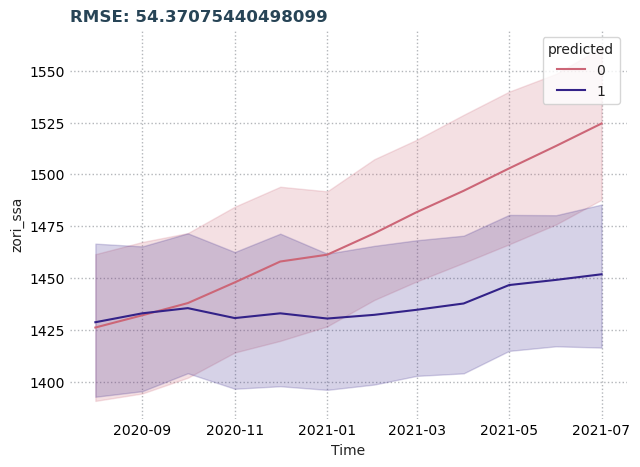

In [43]:
graph_df1 = test[['Time',y_val]]
graph_df1.loc[:,'predicted'] = 0 
graph_df2 = test[['Time','pred']].rename(columns={'pred':y_val})
graph_df2.loc[:,'predicted'] = 1
graph_df = pd.concat([graph_df1,graph_df2]).reset_index(drop=True)

g = sns.lineplot(data = graph_df, x = 'Time',y = y_val, hue = 'predicted')
plt.title(f'RMSE: {rms}')
plt.show()

In [44]:
coef_df = pd.DataFrame({'features':test[X_vals].columns,'coefs':clf.best_estimator_.coef_})
coef_df = coef_df[coef_df['coefs']!=0]
coef_df['coefs_abs'] = abs(coef_df['coefs'])
coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True)
coef_df

features       coefs   coefs_abs
0                             zori_ssa_18_month_shift  125.603324  125.603324
1                             zori_ssa_12_month_shift  113.418199  113.418199
2                              zori_ssa_1_diff_lag_12   21.684692   21.684692
3   women_with_less_one_year_college_per_diff_last...   -1.871521    1.871521
4                         zori_ssa_12_diff_lag_12_per    1.647441    1.647441
5   housing_units_single_family_detached_rented_pe...    1.553778    1.553778
6   top_5_percent_lower_limit_per_diff_last_year_2...    1.235695    1.235695
7   total_population_in_renter_occupied_units_per_...   -1.225925    1.225925
8     male_55_to_59_per_diff_last_year_24_month_shift    0.776302    0.776302
9   female_55_to_59_per_diff_last_year_24_month_shift    0.725946    0.725946
10  women_with_one_year_or_more_college_per_diff_l...    0.647465    0.647465
11  median_contract_rent_per_diff_last_year_24_mon...   -0.610138    0.610138
12  housing_units_built_1990_to_1999_per_diff_last...    0.602275    0.602275
13  housing_units_built_1980_to_1989_per_diff_last...   -0.490896    0.490896
14          male_21_per_diff_last_year_24_month_shift    0.436349    0.436349
15  men_with_hs_diploma_per_diff_last_year_24_mont...    0.435435    0.435435
16  men_with_one_year_or_more_college_per_diff_las...   -0.420755    0.420755
17  housing_units_3_to_4_units_per_diff_last_year_...    0.393775    0.393775
18      total_units_per_diff_last_year_24_month_shift   -0.393398    0.393398
19    widowed_women_per_diff_last_year_24_month_shift    0.381613    0.381613
20          male_20_per_diff_last_year_24_month_shift    0.333584    0.333584
21  men_with_professional_degree_per_diff_last_yea...   -0.299135    0.299135
22  married_men_spouse_present_per_diff_last_year_...   -0.289941    0.289941
23  average_household_size_renters_per_diff_last_y...   -0.231874    0.231874
24  total_population_in_occupied_units_per_diff_la...   -0.224819    0.224819
25  men_with_masters_degree_per_diff_last_year_24_...   -0.223609    0.223609
26  housing_units_over_50_units_per_diff_last_year...   -0.213215    0.213215
27  female_35_to_39_per_diff_last_year_24_month_shift   -0.177958    0.177958
28  married_men_spouse_absent_per_diff_last_year_2...    0.156784    0.156784
29    male_70_to_74_per_diff_last_year_24_month_shift   -0.155278    0.155278
30  male_population_per_diff_last_year_24_month_shift   -0.154211    0.154211
31  carpool_population_per_diff_last_year_24_month...    0.143340    0.143340
32    male_30_to_34_per_diff_last_year_24_month_shift   -0.140661    0.140661
33  women_with_bachelors_degree_per_diff_last_year...   -0.070042    0.070042
34        female_21_per_diff_last_year_24_month_shift    0.066662    0.066662
35  women_with_associate_degree_per_diff_last_year...   -0.066287    0.066287
36       median_age_per_diff_last_year_24_month_shift    0.066191    0.066191
37   occupied_units_per_diff_last_year_24_month_shift   -0.022886    0.022886
38  married_women_spouse_present_per_diff_last_yea...   -0.010577    0.010577
39  transit_population_per_diff_last_year_24_month...   -0.002118    0.002118

In [15]:
coef_df = pd.DataFrame({'features':test[X_vals].columns,'coefs':clf.best_estimator_.coef_})
coef_df = coef_df[coef_df['coefs']!=0]
coef_df['coefs_abs'] = abs(coef_df['coefs'])
coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True)
coef_df

features       coefs   coefs_abs
0                             zori_ssa_18_month_shift  122.290440  122.290440
1                             zori_ssa_12_month_shift  115.182088  115.182088
2                              zori_ssa_1_diff_lag_12   20.603132   20.603132
3   housing_units_over_50_units_rented_24_month_shift   -3.002155    3.002155
4                 median_contract_rent_24_month_shift   -2.500527    2.500527
5   housing_units_single_family_attached_owned_24_...   -1.971487    1.971487
6             men_with_doctoral_degree_24_month_shift   -1.572055    1.572055
7   housing_units_single_family_attached_rented_24...    1.492144    1.492144
8     housing_units_built_1960_to_1969_24_month_shift    1.307050    1.307050
9                        male_80_to_84_24_month_shift   -0.817185    0.817185
10                       male_30_to_34_24_month_shift   -0.681207    0.681207
11                  transit_population_24_month_shift   -0.661365    0.661365
12    housing_units_mobile_home_rented_24_month_shift   -0.654367    0.654367
13      average_household_size_renters_24_month_shift    0.623759    0.623759
14              quintile_2_upper_limit_24_month_shift   -0.611063    0.611063
15           top_5_percent_lower_limit_24_month_shift   -0.442469    0.442469
16                           female_21_24_month_shift   -0.372709    0.372709
17              quintile_2_mean_income_24_month_shift   -0.340356    0.340356
18                          median_age_24_month_shift    0.311555    0.311555
19    housing_units_built_1950_to_1959_24_month_shift    0.241775    0.241775
20        working_from_home_population_24_month_shift    0.155156    0.155156
21      men_with_less_one_year_college_24_month_shift    0.151698    0.151698
22               motorcycle_population_24_month_shift    0.105976    0.105976
23        housing_units_20_to_49_units_24_month_shift   -0.020033    0.020033

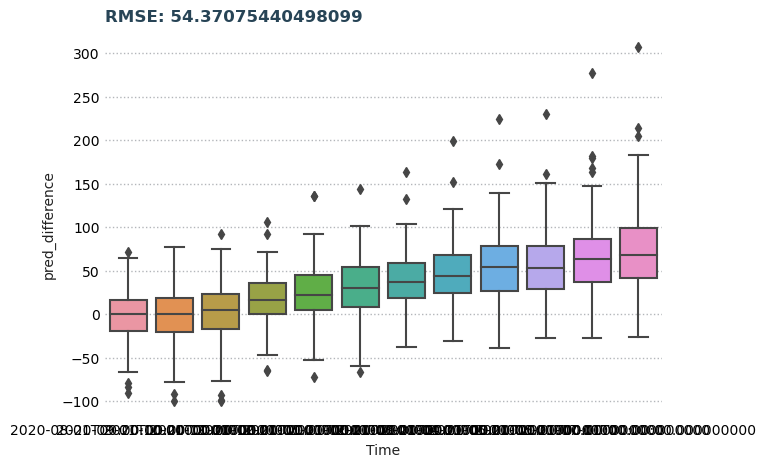

In [45]:
graph_df = test
graph_df['month'] = graph_df['Time'].dt.month
g = sns.boxplot(data = graph_df, x = 'Time',y = 'pred_difference', 
                )
plt.title(f'RMSE: {rms}')
plt.show()

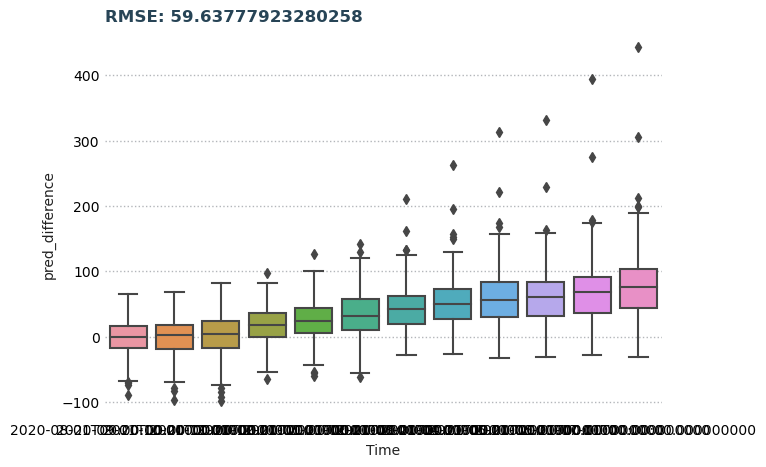

In [16]:
# graph_df = test
# graph_df['month'] = graph_df['Time'].dt.month
# g = sns.boxplot(data = graph_df, x = 'Time',y = 'pred_difference', 
#                 )
# plt.title(f'RMSE: {rms}')
# plt.show()

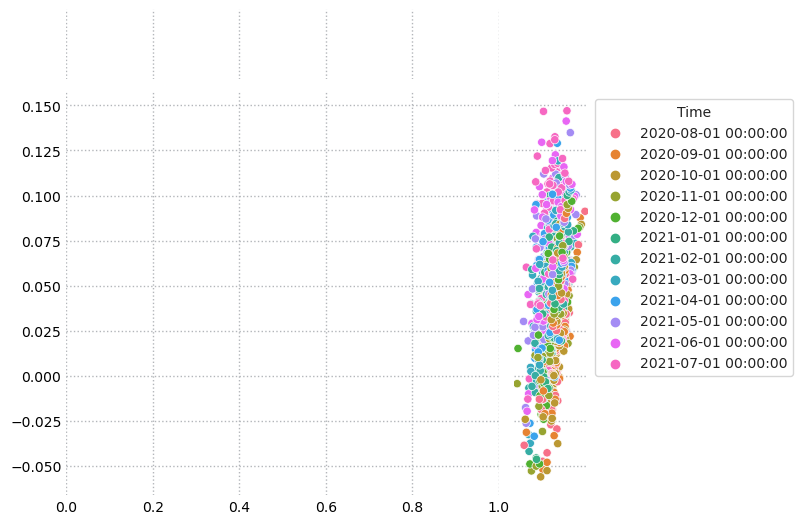

In [47]:
test['pred_12_month_growth'] = test['pred'] - test['zori_ssa_12_month_shift']
test['actual_12_month_growth'] = test['zori_ssa'] - test['zori_ssa_12_month_shift']

test['pred_12_month_growth_per'] = test['pred_12_month_growth']/test['zori_ssa_12_month_shift']
test['actual_12_month_growth_per'] = test['actual_12_month_growth']/test['zori_ssa_12_month_shift']
test['pred_difference_per'] = test['pred_difference']/test['zori_ssa_12_month_shift']
# test['month'] = test['Time'].dt.month

g = sns.scatterplot(data = test, x = 'pred_12_month_growth_per', 
                y = 'actual_12_month_growth_per', hue='Time')

sns.move_legend(g,"upper left", bbox_to_anchor=(1, 1))
plt.show()

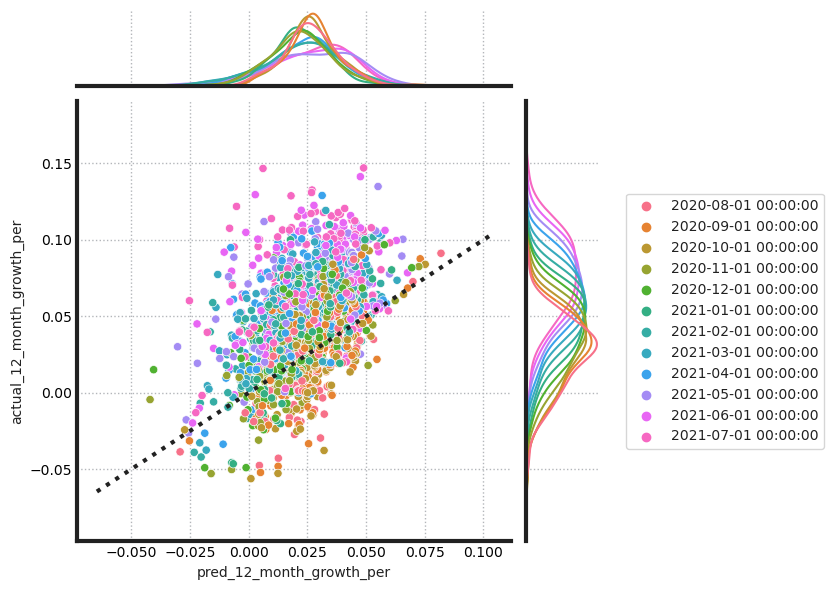

In [48]:
g = sns.JointGrid(data=test, x = 'pred_12_month_growth_per', 
                y = 'actual_12_month_growth_per', hue='Time',
                 )


g.plot_joint(sns.scatterplot,)
g.plot_marginals(sns.kdeplot,legend=False)

g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')

plt.show()

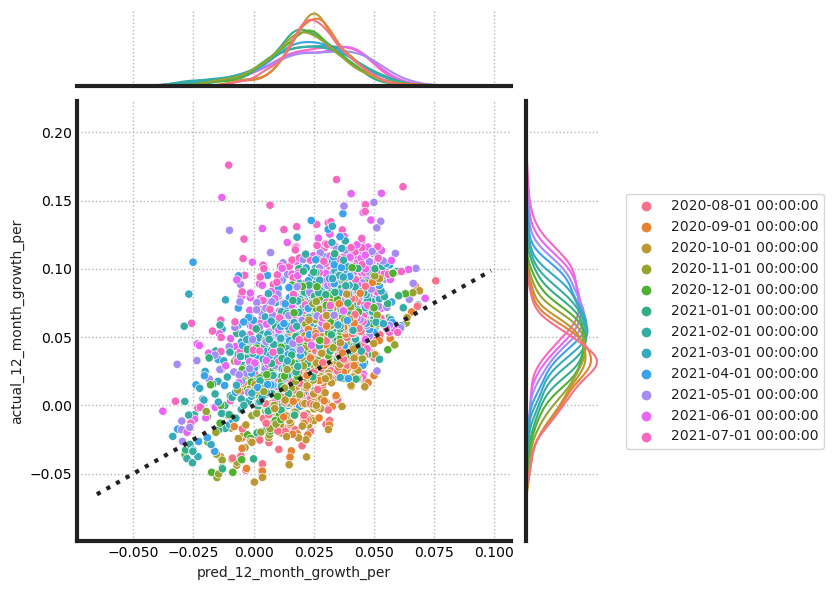

In [18]:
g = sns.JointGrid(data=test, x = 'pred_12_month_growth_per', 
                y = 'actual_12_month_growth_per', hue='Time',
                 )


g.plot_joint(sns.scatterplot,)
g.plot_marginals(sns.kdeplot,legend=False)

g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')

plt.show()


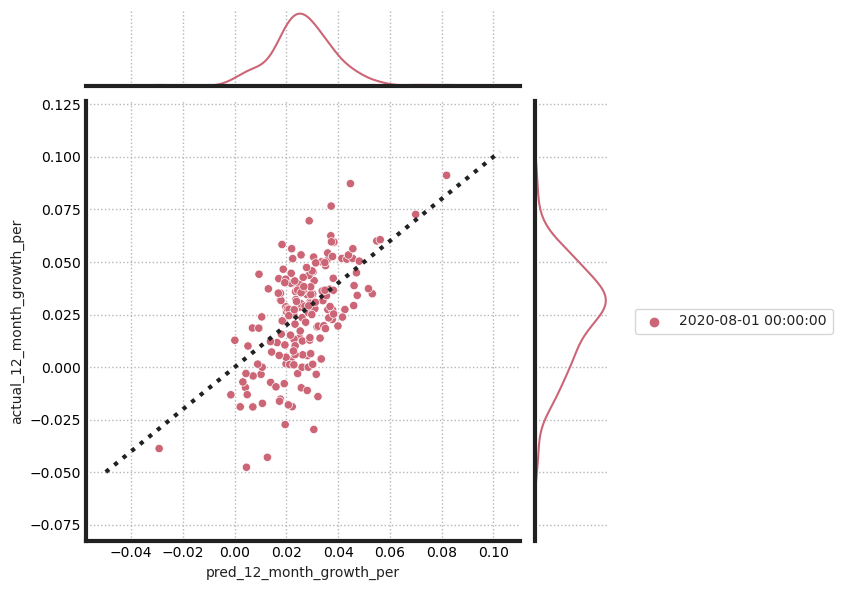

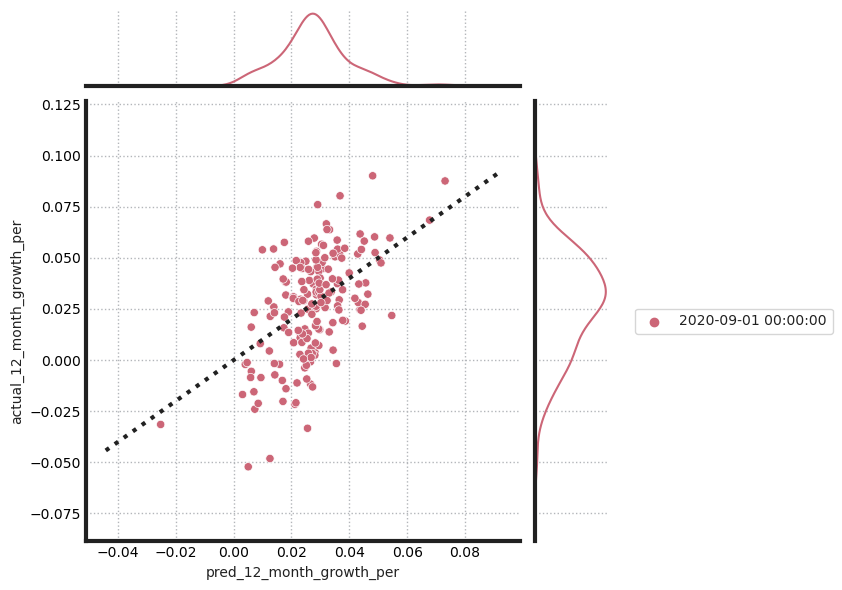

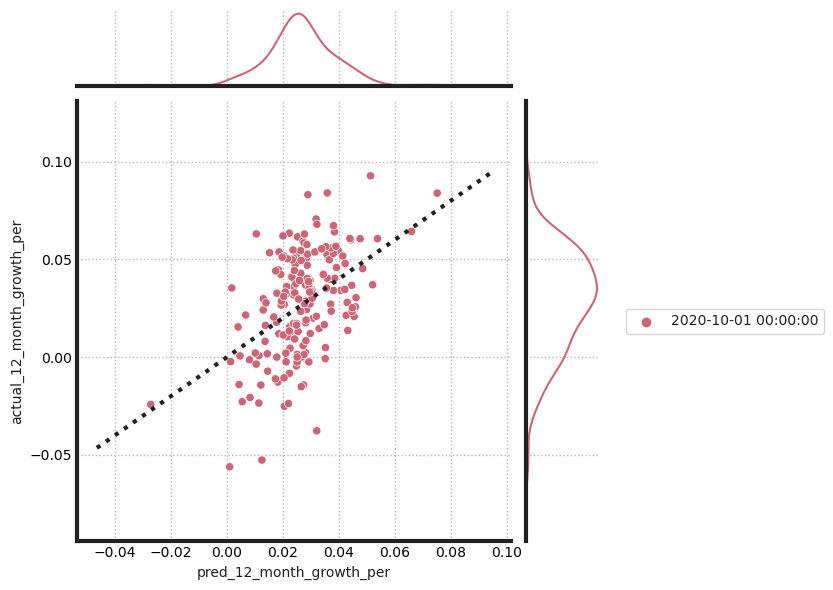

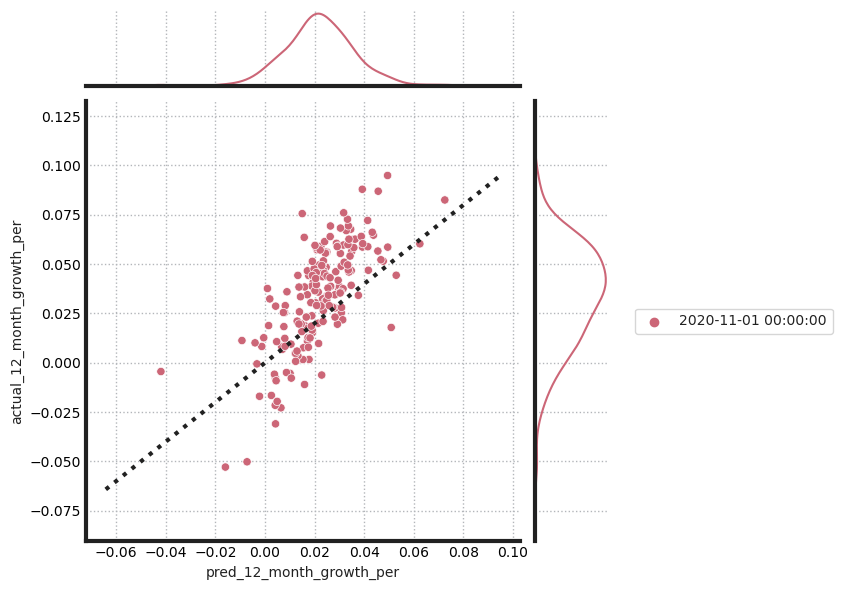

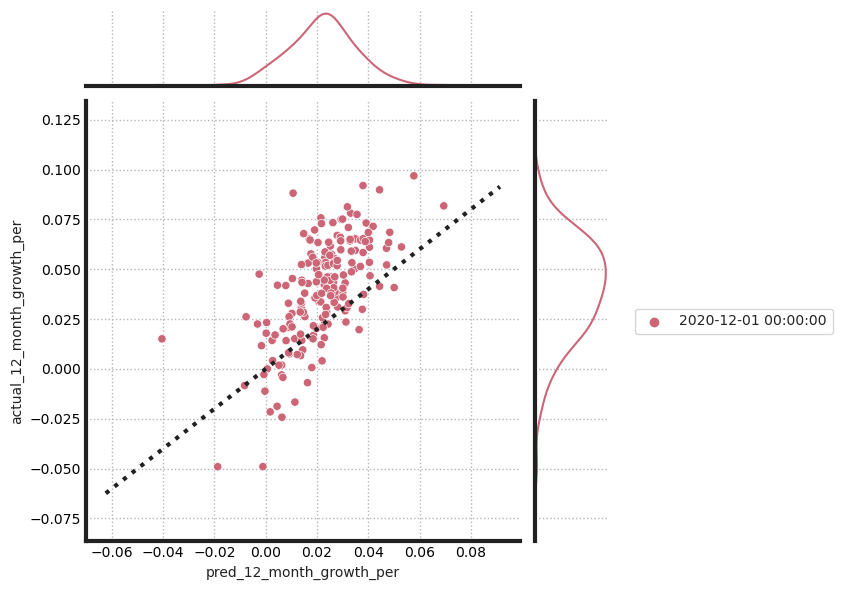

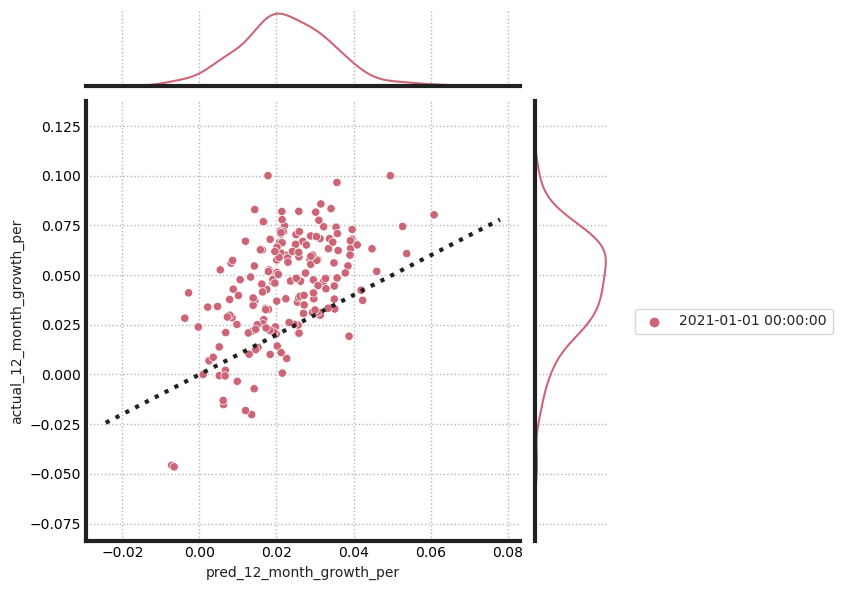

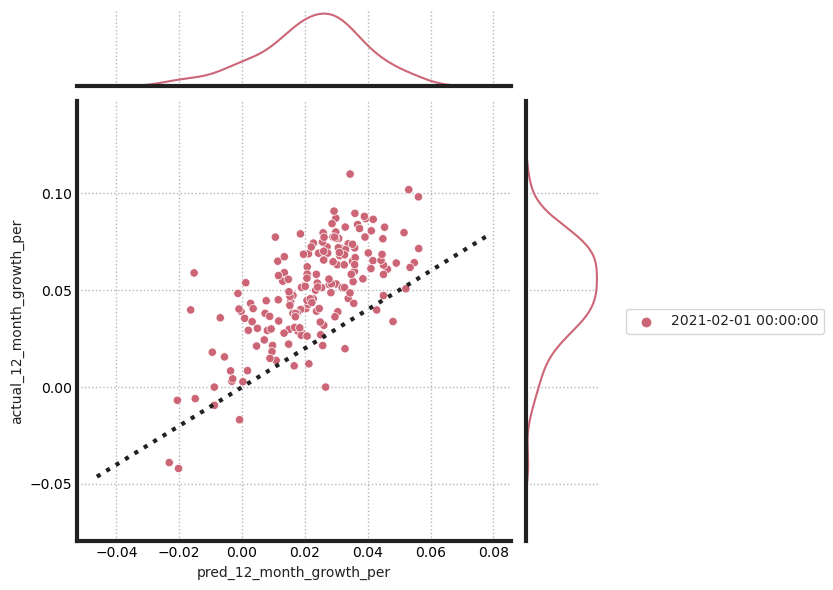

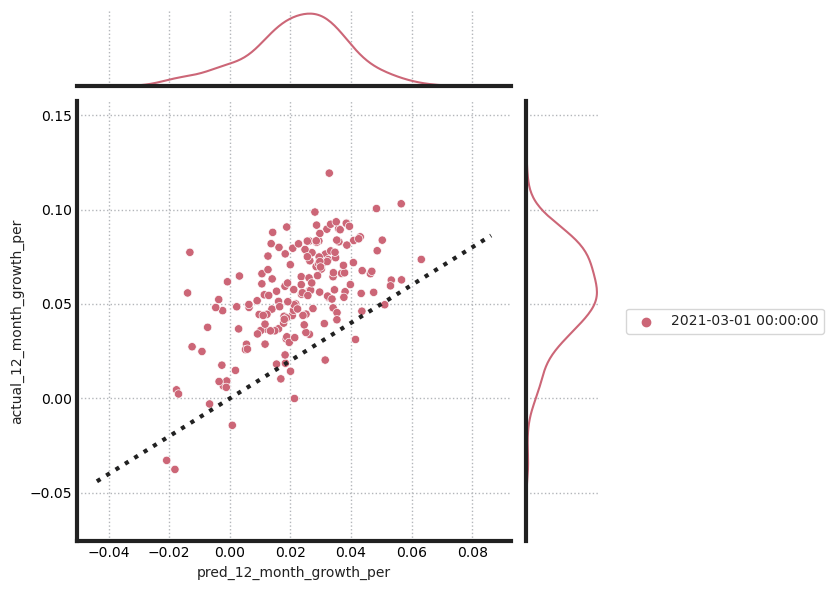

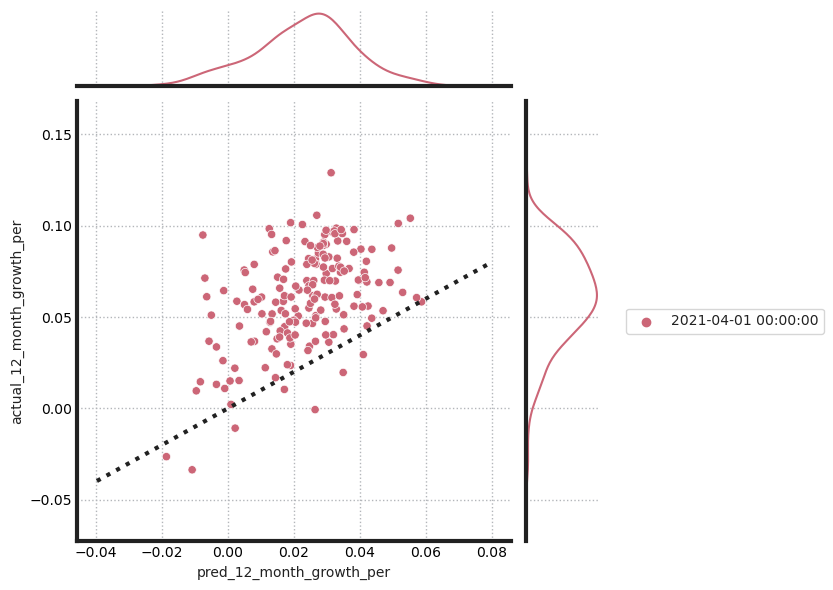

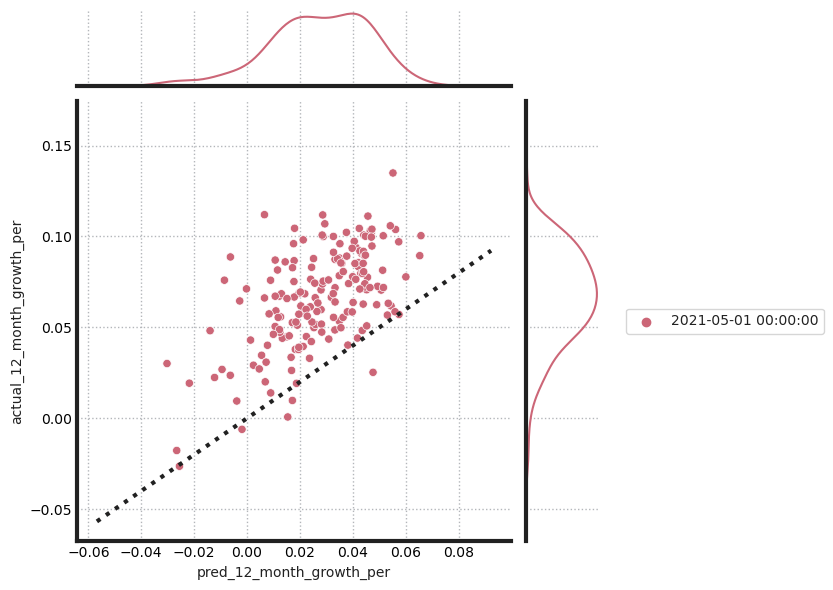

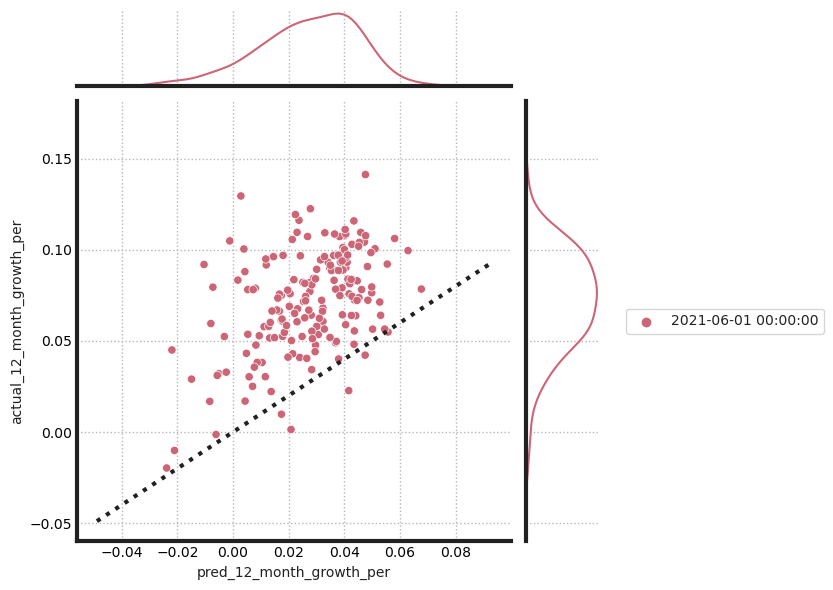

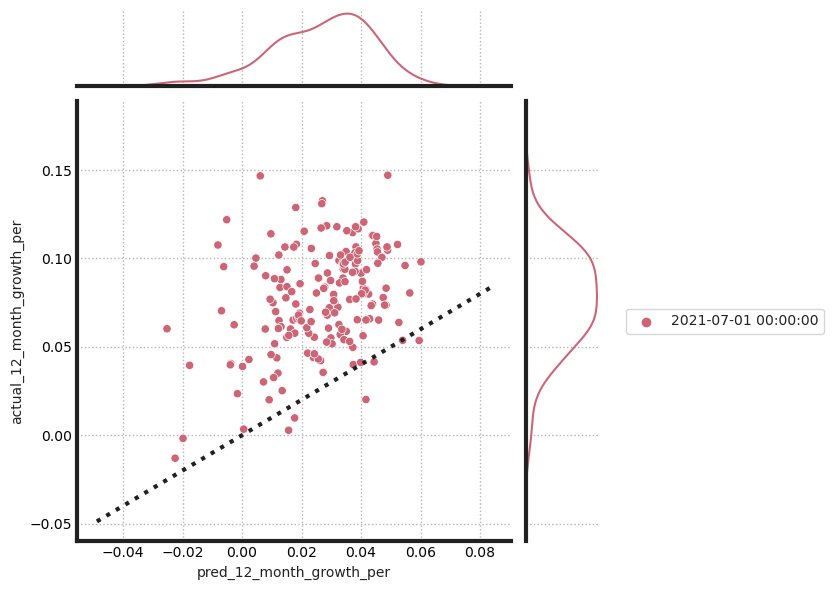

In [49]:

for month in test.Time.unique():
    g = sns.JointGrid(data=test[test['Time']==month], x = 'pred_12_month_growth_per', 
                    y = 'actual_12_month_growth_per', hue='Time',
                     )


    g.plot_joint(sns.scatterplot,)
    g.plot_marginals(sns.kdeplot,legend=False)

    g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')
    g.fig.suptitle("")
    plt.show()

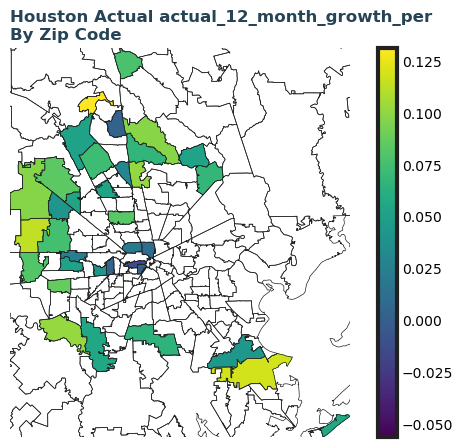

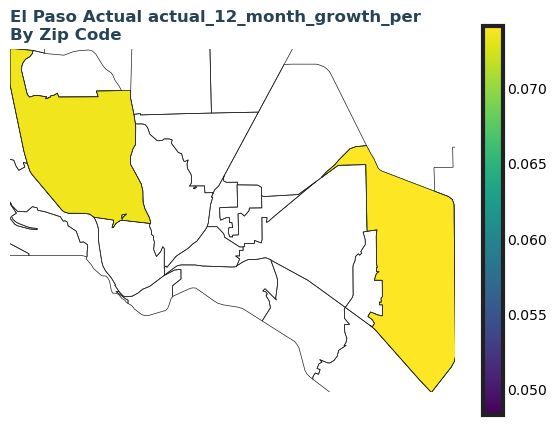

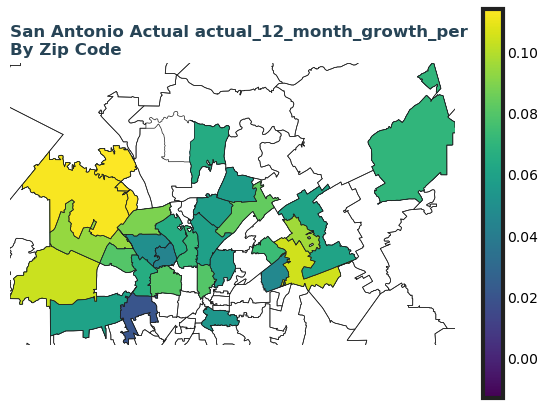

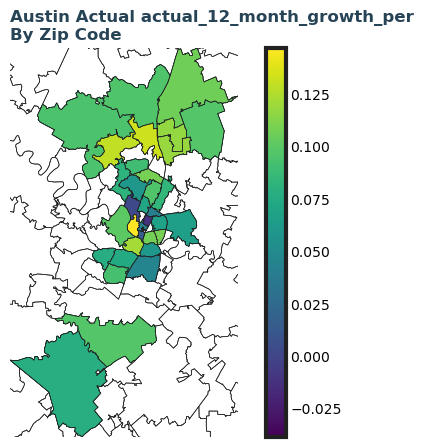

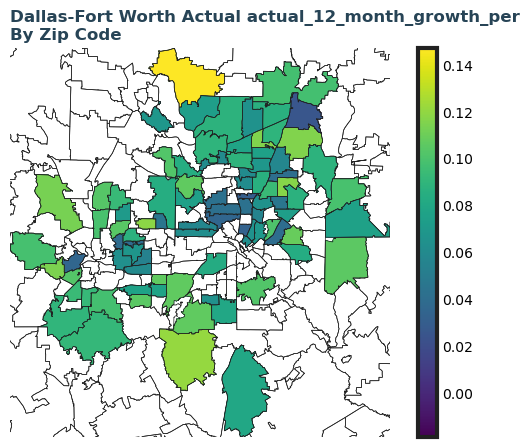

In [50]:
map_ = test
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():


    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["actual_12_month_growth_per"], 
    #               scheme='equal_interval', k=4,
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' Actual actual_12_month_growth_per\nBy Zip Code')
    plt.show()

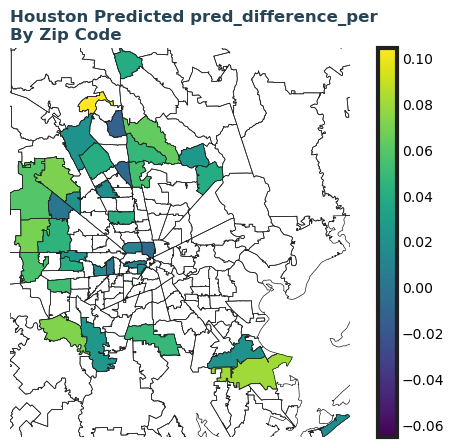

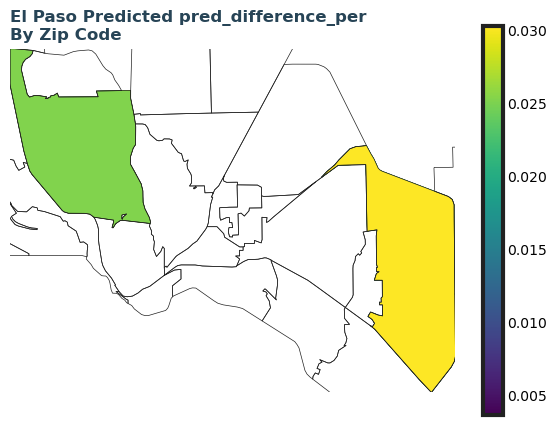

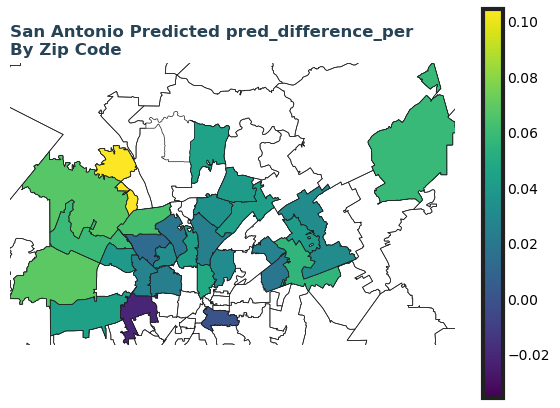

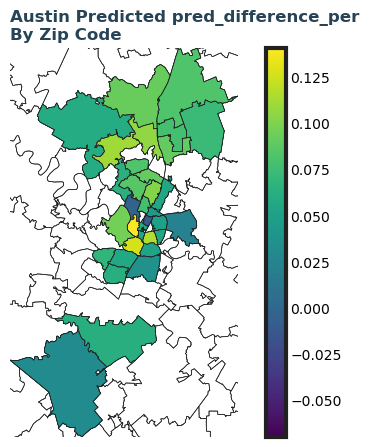

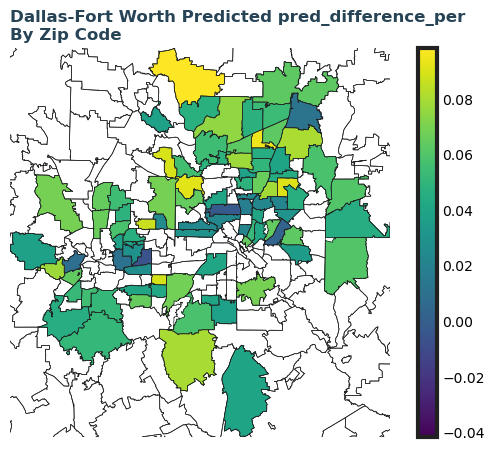

In [51]:
map_ = test
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():


    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["pred_difference_per"], 
    #               scheme='equal_interval', k=4,
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro+' Predicted pred_difference_per\nBy Zip Code')
    plt.show()

In [52]:
five_per_zips = list(test[test['pred_12_month_growth_per']>.05].zip_code.unique())
naive_five_per_zips = list(test[test['zori_ssa_12_diff_lag_12_per']>.05].zip_code.unique())


In [53]:
test.loc[:,'invest_rec_5_per'] = 0
test.loc[test['zip_code'].isin(five_per_zips),'invest_rec_5_per'] = 3
test.loc[test['zip_code'].isin(naive_five_per_zips),'invest_rec_5_per'] = 1
test.loc[(test['zip_code'].isin(naive_five_per_zips) &
          test['zip_code'].isin(five_per_zips))
          ,'invest_rec_5_per'] = 2


In [54]:
test.loc[test['invest_rec_5_per']==3,'zip_code'].unique()

array([79936, 79912, 75243, 78240, 78228, 75149, 78216, 78109, 78229,
       76227, 77073, 78023, 75041, 78148])

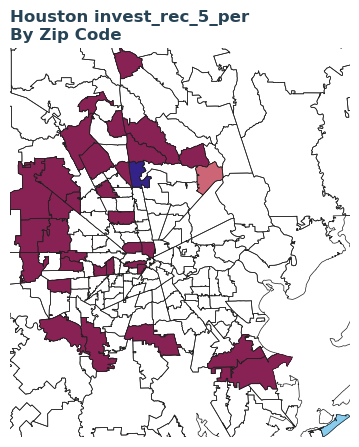

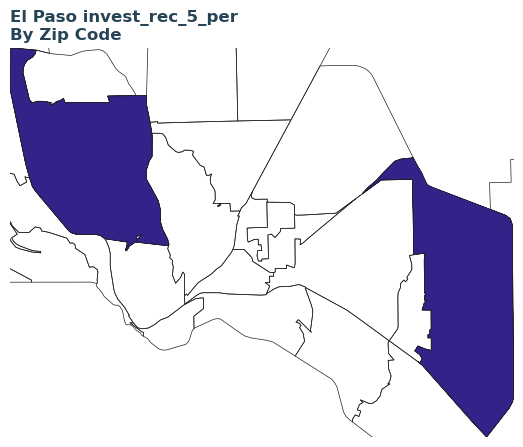

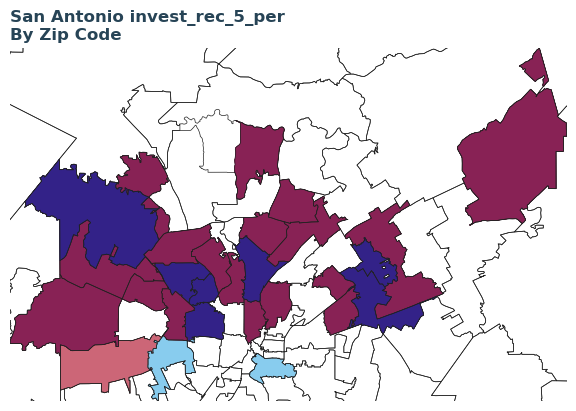

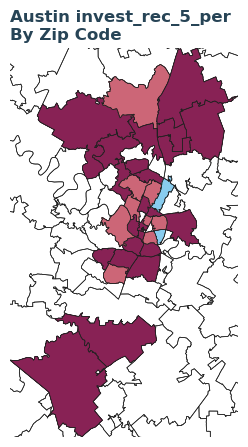

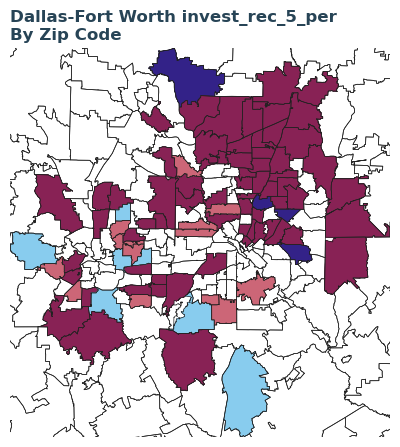

In [55]:
color = ['#882255','#cc6677','#88ccee','#332288']
zips_code = [0,1,2,3]
color_mapping = dict(zip(zips_code,color))

map_ = test
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
#                      column = graph_df["invest_rec_5_per"], 
                  color=graph_df["invest_rec_5_per"].map(color_mapping),
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' invest_rec_5_per\nBy Zip Code')
    plt.show()

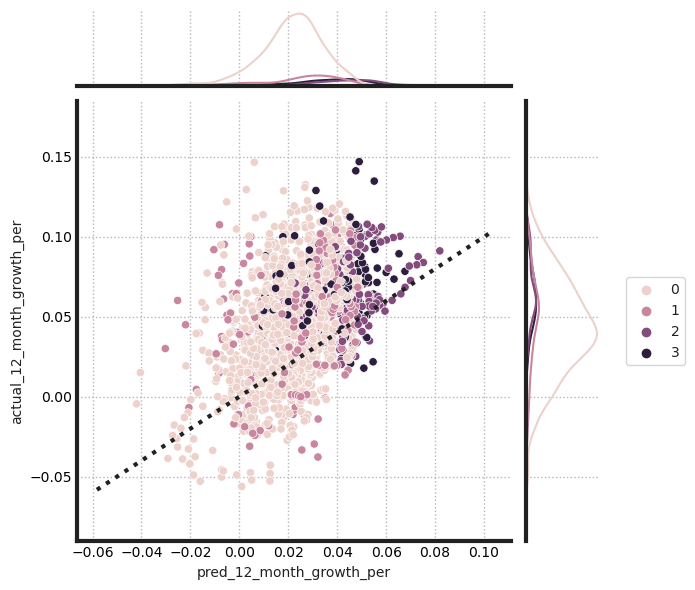

In [56]:
g = sns.JointGrid(data=test, x = 'pred_12_month_growth_per', 
                y = 'actual_12_month_growth_per', hue='invest_rec_5_per',
                 )


g.plot_joint(sns.scatterplot,)
g.plot_marginals(sns.kdeplot,legend=False)

g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')

plt.show()

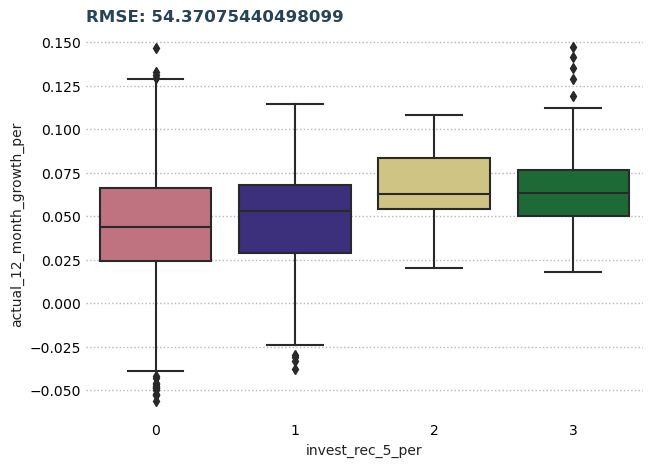

In [57]:
graph_df = test
graph_df['month'] = graph_df['Time'].dt.month
g = sns.boxplot(data = graph_df, x = 'invest_rec_5_per',y = 'actual_12_month_growth_per', 
                )
plt.title(f'RMSE: {rms}')
plt.show()

In [ ]:
# # zri_shift 6-12 months
# zri_shift, zri_shift_X_vals = helper.time_lag_merge(zri, zri, {
#     6:['zori_ssa'],
#     7:['zori_ssa'],
#     12:['zori_ssa'],
#     18:['zori_ssa']
# },
#                                           return_cols = True
#                                          )
# zri_shift = zri_shift.dropna(axis='index',how = 'any').reset_index(drop = True)
# # Adding the shift values
# zri_shift.loc[:,'zori_ssa_1_diff__lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
#                                              zri_shift.loc[:,'zori_ssa_7_month_shift'])
# zri_shift.loc[:,'zori_ssa_6_diff_lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
#                                              zri_shift.loc[:,'zori_ssa_12_month_shift'])
# zri_shift.loc[:,'zori_ssa_12_diff_lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
#                                              zri_shift.loc[:,'zori_ssa_18_month_shift'])
# zri_shift = zri_shift[['Time','zip_code','zori_ssa','zori_ssa_6_month_shift',
#                        'zori_ssa_12_month_shift',
#                        'zori_ssa_1_diff__lag_6','zori_ssa_6_diff_lag_6',
#                        'zori_ssa_12_diff_lag_6']]


In [ ]:
# X_vals = ['zori_ssa_6_month_shift',
#                        'zori_ssa_12_month_shift',
#                        'zori_ssa_1_diff__lag_6','zori_ssa_6_diff_lag_6',
#                        'zori_ssa_12_diff_lag_6']
# y_val = 'zori_ssa'

# # for metro in metros:
# train = zri_shift.loc[zri_shift['Time']<datetime.datetime(2021,1,2),:].reset_index(drop=True)
# test = zri_shift.loc[zri_shift['Time']>datetime.datetime(2021,1,2),:].reset_index(drop=True)
# cat_feats_=[]

# scaler = StandardScaler(with_mean=False)
# lasso = Lasso(max_iter = 50000, random_state = 33)

# X = train[X_vals]
# transformer = ColumnTransformer([("Cat", 
#                                   OneHotEncoder(handle_unknown = 'ignore'), 
#                                   cat_feats_)], remainder='passthrough')
# X = transformer.fit_transform(X)
# X = scaler.fit_transform(X)
# y = train[y_val]

# # Grid Search set up.

# alphas = [0.3, 0.6, 1]
# tuned_parameters = [{'alpha': alphas}]
# print(f'Performing Grid Search with alphas of: {alphas}')
# clf = GridSearchCV(lasso, tuned_parameters, 
#                     cv=3,n_jobs = -1,
#                   scoring = 'neg_root_mean_squared_error')
# # best_alpha = clf.best_params_['alpha']
# clf.fit(X, y)

# X_test = test[X_vals]
# X_test = transformer.transform(X_test)
# X_test = scaler.transform(X_test)
# y_test = test[y_val]
# y_predicted = clf.predict(X_test)
# test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_predicted

# rms = mean_squared_error(y_test, y_predicted, squared=False)
# test.loc[:,'pred'] = y_predicted

In [ ]:
# test['pred_6_month_growth'] = test['pred'] - test['zori_ssa_6_month_shift']
# test['actual_6_month_growth'] = test['zori_ssa'] - test['zori_ssa_6_month_shift']

In [ ]:
# test['pred_6_month_growth_per'] = test['pred_6_month_growth']/test['zori_ssa_6_month_shift']
# test['actual_6_month_growth_per'] = test['actual_6_month_growth']/test['zori_ssa_6_month_shift']
# test['pred_difference_per'] = test['pred_difference']/test['zori_ssa_6_month_shift']
# test['month'] = test['Time'].dt.month


In [ ]:
# g = sns.scatterplot(data = test, x = 'pred_6_month_growth_per', 
#                 y = 'actual_6_month_growth_per', hue='Time')

# sns.move_legend(g,"upper left", bbox_to_anchor=(1, 1))
# plt.show()

In [ ]:
# g = sns.JointGrid(data=test, x = 'pred_6_month_growth_per', 
#                 y = 'actual_6_month_growth_per', hue='Time',
#                  )


# g.plot_joint(sns.scatterplot,)
# g.plot_marginals(sns.kdeplot,legend=False)

# g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
# x0, x1 = g.ax_joint.get_xlim()
# y0, y1 = g.ax_joint.get_ylim()
# lims = [max(x0, y0), min(x1, y1)]
# g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')

# plt.show()

In [ ]:
# g = sns.scatterplot(data = test, x = 'pred_6_month_growth', y = 'actual_6_month_growth', 
#                hue = 'Time')

# sns.move_legend(g,"upper left", bbox_to_anchor=(1, 1))

# plt.show()

In [ ]:
# sns.scatterplot(data = test, x = 'pred_6_month_growth', y = 'actual_6_month_growth', 
#                hue = 'pred_difference')
# plt.show()

In [ ]:
# sns.scatterplot(data = test[test['month']==7], x = 'pred_6_month_growth', y = 'actual_6_month_growth', 
#                hue = 'pred_difference')
# plt.show()

In [ ]:
# graph_df1 = test[['Time',y_val]]
# graph_df1.loc[:,'predicted'] = 0 
# graph_df2 = test[['Time','pred']].rename(columns={'pred':y_val})
# graph_df2.loc[:,'predicted'] = 1
# graph_df = pd.concat([graph_df1,graph_df2]).reset_index(drop=True)

# g = sns.lineplot(data = graph_df, x = 'Time',y = y_val, hue = 'predicted')
# plt.title(f'RMSE: {rms}')
# plt.show()

In [ ]:
# sns.lineplot(data = zri,  x = 'Time',y = y_val)
# plt.show()

In [ ]:
# graph_df = test
# graph_df['month'] = graph_df['Time'].dt.month
# g = sns.boxplot(data = graph_df, x = 'month',y = 'pred_difference', 
#                 )
# plt.title(f'RMSE: {rms}')
# plt.show()

In [ ]:
# coef_df = pd.DataFrame({'features':test[X_vals].columns,'coefs':clf.best_estimator_.coef_})
# coef_df = coef_df[coef_df['coefs']!=0]
# coef_df['coefs_abs'] = abs(coef_df['coefs'])
# coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True)
# coef_df

In [ ]:
# map_ = test[test['Time'].dt.month==4]
# # dictionary of each cities zipcodes
# different_metros = {'Houston' : houston_zips, 
#                     'El Paso' : paso_zips, 
#                     'San Antonio' : san_zips, 
#                     'Austin' : austin_zips, 
#                     'Dallas-Fort Worth' : dallas_zips}

# # looping the graphing to make sure it works
# for metro in different_metros.keys():


#     graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
#     fig,ax = plt.subplots()
#     zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
#     graph_df.plot(ax=zip_boundry_map, 
#                      column = graph_df["pred_difference"], 
#     #               scheme='equal_interval', k=4,
#                   legend=True,
#                     )

#     zip_boundry_map.axis('off')

#     minx, miny, maxx, maxy = graph_df.total_bounds
#     ax.set_xlim(minx, maxx)
#     ax.set_ylim(miny, maxy)
#     plt.title(metro+' Predicted Difference\nBy Zip Code')
#     plt.show()

In [ ]:
# map_ = test[test['Time'].dt.month==4]
# # dictionary of each cities zipcodes
# different_metros = {'Houston' : houston_zips, 
#                     'El Paso' : paso_zips, 
#                     'San Antonio' : san_zips, 
#                     'Austin' : austin_zips, 
#                     'Dallas-Fort Worth' : dallas_zips}

# # looping the graphing to make sure it works
# for metro in different_metros.keys():


#     graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
#     fig,ax = plt.subplots()
#     zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
#     graph_df.plot(ax=zip_boundry_map, 
#                      column = graph_df["zori_ssa"], 
#     #               scheme='equal_interval', k=4,
#                   legend=True,
#                     )

#     zip_boundry_map.axis('off')

#     minx, miny, maxx, maxy = graph_df.total_bounds
#     ax.set_xlim(minx, maxx)
#     ax.set_ylim(miny, maxy)
#     plt.title(metro +' Actual ZRI\nBy Zip Code')
#     plt.show()